In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from graphviz import Source
from sklearn import tree
from IPython.display import SVG



## Project Settings

Specified here are the paths for the data and the features to run over in the list of best features.
Each entry in the list is a list containing one single string of the features to try, comma seperated. In this way it is easy to write a script to 
add entries to try very easily. 

In [2]:

##### set parameters
path_train_data = 'train.csv'
path_test_data = 'test.csv'
path_all_data = 'Dataset Correlated Removed.csv'

# set features here

best_features = [
['C_R1, nof_negCharge, Complexity, PSA/Area, molPSA, molLogS, molVolume'],
['C_R1, Complexity, nof_HBD, nof_HBA, PSA/Area, molArea, molLogP'],
['C_R1, nof_negCharge, Complexity, nof_HBA, PSA/Area, molArea, molLogS'],
['C_R1, nof_negCharge, nof_HBA, nof_Atoms, PSA/Area, molLogS, molLogP'],
['posCharge/Volume, Complexity, nof_HBD, nof_HBA, molArea, molLogS, molVolume'],
['nof_RotB, posCharge/Volume, Complexity, nof_HBD, nof_HBA, molArea, molVolume'],
['Complexity, nof_HBA, nof_Atoms, PSA/Area, molArea, molLogS, molVolume'],
['Complexity, nof_HBD, nof_Chirals, PSA/Area, molArea, molLogP, molVolume'],
['Complexity, molCharge_total, nof_HBA, nof_Atoms, PSA/Area, molArea, molVolume'],
['nof_posCharge, Complexity, nof_HBD, PSA/Area, molArea, molLogP, molVolume'],
['nof_negCharge, Complexity, nof_Atoms, PSA/Area, molArea, molLogP, molVolume'],
['nof_negCharge, Complexity, nof_HBA, nof_Atoms, PSA/Area, molArea, molVolume'],
['C_R1, Complexity, nof_Atoms, PSA/Area, molPSA, molLogS, molVolume'],
['C_R1, Complexity, nof_HBA, molPSA, molLogS, molLogP, molVolume'],
['C_R1, Complexity, molCharge_total, nof_HBA, PSA/Area, molArea, molLogS'],
['C_R1, nof_posCharge, Complexity, PSA/Area, molPSA, molLogS, molVolume'],
['C_R1, nof_negCharge, Complexity, molCharge_total, nof_HBA, PSA/Area, molArea'],

]

best_features = [list(map(str.strip, x[0].split(','))) for x in best_features]

k = len(best_features)


## Load Dataset

This code loads dataset into the variables below and converts the labels to categorical 0, 1 pairs.

In [3]:
# load dataset
all_data = pd.DataFrame(pd.read_csv(path_all_data))
all_labels = all_data['SLC'].astype('category').cat.codes
# drop labels
all_data.drop('SLC', axis=1, inplace=True)

train_data = pd.DataFrame(pd.read_csv(path_train_data))
train_labels = train_data['SLC'].astype('category').cat.codes
# drop labels

train_data.drop('SLC', axis=1, inplace=True)

test_data = pd.DataFrame(pd.read_csv(path_test_data))
test_labels = test_data['SLC'].astype('category').cat.codes
# drop labels
test_data.drop('SLC', axis=1, inplace=True)


## AUC and Classification Accuracy - decision tree

The code below will find the classification accuracy using 10-fold cross-validation using stratified sampling to help class imbalance. The AUC on the test split is also found.

In [5]:
# visualize decision tree for input features
''' HYPERPARAMS FOR DECISION TREE
 
 These parameters implement a rudimentary pruning algorithm, would ideally like to use AB pruning'''
enable_pruning = True
# maximum depth of dtree
max_depth = 5
# how many samples your need atleast, at a LEAF node
min_samples = 3

d_trees = []


# find CA - uses 10-fold cross validation 
# with stratified sampling to help with class imbalance
# and simple average over subsets
dt_cas = []

for i in range(k):
    aucs = []
    # make fold
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for trx, tex in skf.split(all_data, all_labels):
        # strip data to required features
        subset_data = all_data.filter(best_features[i], axis=1)
        
        # find auc
        dtree = DecisionTreeClassifier(presort=True, max_depth=max_depth, min_samples_leaf=min_samples)
        dtree.fit(subset_data.iloc[trx, :], all_labels.iloc[trx])        
        pred = dtree.predict(subset_data.iloc[tex, :])
        labels = all_labels.iloc[tex]
        
        acc = roc_auc_score(labels, pred)
        # record auc to average later
        aucs.append(acc)
    
    dt_cas.append(np.mean(aucs))
    

# find AUC 
dt_aucs = []
for i in range(k):
    subset_test_data = test_data.filter(best_features[i], axis=1)
    subset_train_data = train_data.filter(best_features[i], axis=1)
    
    clf = DecisionTreeClassifier(presort=True, max_depth=max_depth, min_samples_leaf=min_samples)
    clf.fit(subset_train_data, train_labels)
    d_trees.append(clf)
    
    # make its predictions on test data
    pred = d_trees[i].predict(subset_test_data)
    
    # find auc scores
    auc = roc_auc_score(test_labels, pred)
    
    # record the scores
    dt_aucs.append(auc)
    
print('Decision Tree Results:')
print('\tAUC\tAcc\tFeatures')
for i, f in enumerate(zip(dt_aucs, dt_cas)):
    print('\t%05.3f\t%05.3f\t' % tuple(f) + ', '.join(best_features[i]))

    

Decision Tree Results:
	AUC	Acc	Features
	00.77	00.59	C_R1, nof_negCharge, Complexity, PSA/Area, molPSA, molLogS, molVolume
	00.73	00.69	C_R1, Complexity, nof_HBD, nof_HBA, PSA/Area, molArea, molLogP
	00.73	00.70	C_R1, nof_negCharge, Complexity, nof_HBA, PSA/Area, molArea, molLogS
	00.81	00.54	C_R1, nof_negCharge, nof_HBA, nof_Atoms, PSA/Area, molLogS, molLogP
	00.73	00.73	posCharge/Volume, Complexity, nof_HBD, nof_HBA, molArea, molLogS, molVolume
	00.73	00.71	nof_RotB, posCharge/Volume, Complexity, nof_HBD, nof_HBA, molArea, molVolume
	00.73	00.64	Complexity, nof_HBA, nof_Atoms, PSA/Area, molArea, molLogS, molVolume
	00.85	00.68	Complexity, nof_HBD, nof_Chirals, PSA/Area, molArea, molLogP, molVolume
	00.73	00.68	Complexity, molCharge_total, nof_HBA, nof_Atoms, PSA/Area, molArea, molVolume
	00.85	00.69	nof_posCharge, Complexity, nof_HBD, PSA/Area, molArea, molLogP, molVolume
	00.73	00.65	nof_negCharge, Complexity, nof_Atoms, PSA/Area, molArea, molLogP, molVolume
	00.73	00.69	nof_negCha

## AUC and Classification Accuracy - Random Forest Walk

The code below will find the classification accuracy using 10-fold cross-validation using stratified sampling to help class imbalance. The AUC on the test split is also found.

In [9]:
# visualize random forest features
rfws = []

# find CA - uses 10-fold cross validation 
# with stratified sampling to help with class imbalance
# and simple average over subsets
rfw_cas = []

for i in range(k):
    aucs = []
    # make fold
    skf = StratifiedKFold(n_splits=10, shuffle=True)
    for trx, tex in skf.split(all_data, all_labels):
        # strip data to required features
        subset_data = all_data.filter(best_features[i], axis=1)
        
        # find auc
        rfwtree = RandomForestClassifier(n_estimators=100)
        rfwtree.fit(subset_data.iloc[trx, :], all_labels.iloc[trx])
        pred = rfwtree.predict(subset_data.iloc[tex, :])
        labels = all_labels.iloc[tex]
        
        acc = roc_auc_score(labels, pred)
        # record auc to average later
        aucs.append(acc)
    
    rfw_cas.append(np.mean(aucs))
    

# find AUC 
rfw_aucs = []
for i in range(k):
    subset_test_data = test_data.filter(best_features[i], axis=1)
    subset_train_data = train_data.filter(best_features[i], axis=1)
    
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(subset_train_data, train_labels)
    rfws.append(clf)
    
    # make its predictions on test data
    pred = rfws[i].predict(subset_test_data)
    
    # find auc scores
    auc = roc_auc_score(test_labels, pred)
    
    # record the scores
    rfw_aucs.append(auc)

print('Random Forest Results:')
print('\tAUC\tAcc\tFeatures')
for i, f in enumerate(zip(rfw_aucs, rfw_cas)):
    print('\t%05.3f\t%05.3f\t' % tuple(f) + ', '.join(best_features[i]))


Random Forest Results:
	AUC	Acc	Features
	0.846	0.596	C_R1, nof_negCharge, Complexity, PSA/Area, molPSA, molLogS, molVolume
	0.923	0.733	C_R1, Complexity, nof_HBD, nof_HBA, PSA/Area, molArea, molLogP
	0.923	0.771	C_R1, nof_negCharge, Complexity, nof_HBA, PSA/Area, molArea, molLogS
	0.885	0.642	C_R1, nof_negCharge, nof_HBA, nof_Atoms, PSA/Area, molLogS, molLogP
	0.923	0.713	posCharge/Volume, Complexity, nof_HBD, nof_HBA, molArea, molLogS, molVolume
	0.846	0.733	nof_RotB, posCharge/Volume, Complexity, nof_HBD, nof_HBA, molArea, molVolume
	0.923	0.671	Complexity, nof_HBA, nof_Atoms, PSA/Area, molArea, molLogS, molVolume
	0.923	0.654	Complexity, nof_HBD, nof_Chirals, PSA/Area, molArea, molLogP, molVolume
	0.885	0.688	Complexity, molCharge_total, nof_HBA, nof_Atoms, PSA/Area, molArea, molVolume
	0.923	0.767	nof_posCharge, Complexity, nof_HBD, PSA/Area, molArea, molLogP, molVolume
	0.923	0.729	nof_negCharge, Complexity, nof_Atoms, PSA/Area, molArea, molLogP, molVolume
	0.885	0.729	nof_negCha

## Visualizing individual decision trees

The tree in variable `dtree` is visualized by the cell below. We can see how it is pruned, the splitting rule, etc.

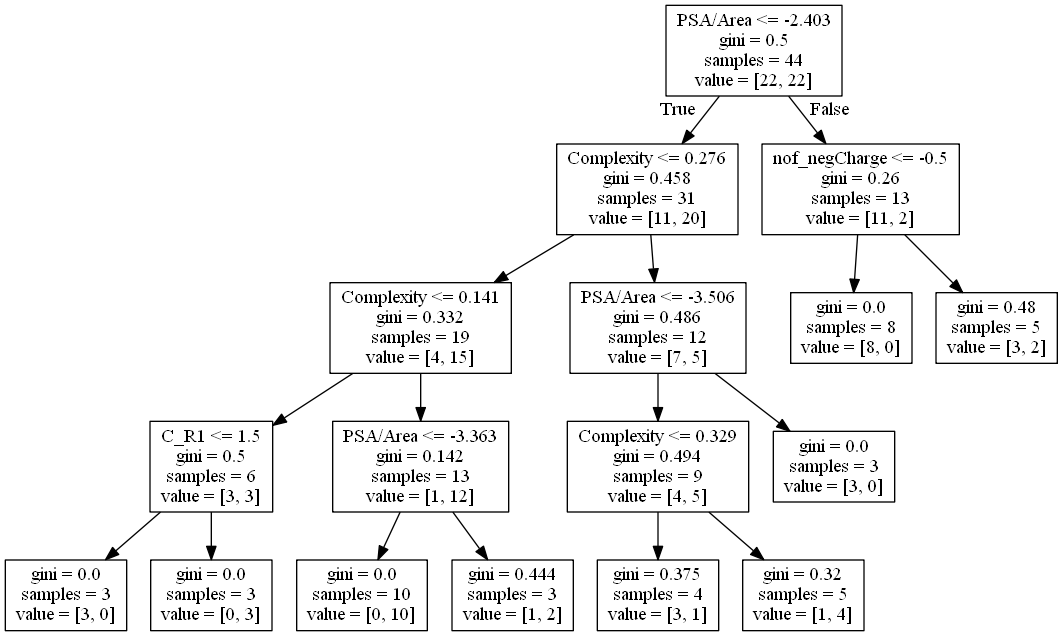

In [7]:
i = 0

dtree = d_trees[0]
graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
SVG(graph.pipe(format='svg'))            
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
graph.format = 'png'
graph.render('dtree_render',view=True)
graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)
Image(png_bytes)

## Feature importance

The feature importances are compared below for decision trees and random forests.
Reported below is code to visualize all decision trees. This requires the graphviz package and has some bugs, which will be reported. This code visualizes all decision trees and finds the feature importances for all of them.

In [8]:
i = 0
# visualization
for dtree in d_trees:
    if i < k:
        print('Feature importances for tree and forest (resp.) %s/%s:' % (i + 1, k))
        for e in zip(dtree.feature_importances_, rfws[i].feature_importances_, best_features[i]):
            print('\t%6f\t%6f\t%s' % e)
        
        try:
            graph = Source(tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            SVG(graph.pipe(format='svg'))            
            graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            graph.format = 'png'
            graph.render('dtree_render',view=True)
            graph = Source( tree.export_graphviz(dtree, out_file=None, feature_names=best_features[i][:dtree.n_features_]))
            png_bytes = graph.pipe(format='png')
            with open('dtree_pipe.png','wb') as f:
                f.write(png_bytes)
            Image(png_bytes)
        except:
            print('Something went wrong with rendering graph')
    else:
        print('Warning, code may be buggy')
    i += 1

Feature importances for tree and forest (resp.) 1/17:
	0.197802	0.159810	C_R1
	0.064920	0.071237	nof_negCharge
	0.320341	0.332214	Complexity
	0.416937	0.436740	PSA/Area
Feature importances for tree and forest (resp.) 2/17:
	0.021739	0.083375	C_R1
	0.000000	0.086295	Complexity
	0.248910	0.127314	nof_HBD
	0.000000	0.187058	nof_HBA
	0.729351	0.353011	PSA/Area
	0.000000	0.162946	molArea
Feature importances for tree and forest (resp.) 3/17:
	0.000000	0.105529	C_R1
	0.026027	0.037848	nof_negCharge
	0.236608	0.122627	Complexity
	0.000000	0.156155	nof_HBA
	0.737366	0.374736	PSA/Area
	0.000000	0.203106	molArea
Feature importances for tree and forest (resp.) 4/17:
	0.002064	0.094588	C_R1
	0.045417	0.036112	nof_negCharge
	0.200890	0.123810	nof_HBA
	0.588127	0.209615	nof_Atoms
	0.163501	0.174066	PSA/Area
	0.000000	0.219070	molLogS
	0.000000	0.142738	molLogP
Feature importances for tree and forest (resp.) 5/17:
	0.000000	0.101508	posCharge/Volume
	0.000000	0.103720	Complexity
	0.270649	0.152324	nof